# Combining RP layers using weighted sum and running zonal statistics

## Compute layers combination

Probability mass weights:
STORM_FIXED_RETURN_PERIODS_GLOBAL_10_YR_RP.tif: 0.0500
STORM_FIXED_RETURN_PERIODS_GLOBAL_20_YR_RP.tif: 0.0300
STORM_FIXED_RETURN_PERIODS_GLOBAL_50_YR_RP.tif: 0.0100
STORM_FIXED_RETURN_PERIODS_GLOBAL_100_YR_RP.tif: 0.0080
STORM_FIXED_RETURN_PERIODS_GLOBAL_500_YR_RP.tif: 0.0020
Reading raster files...
Combining rasters with weights and proper NoData handling...
Combined raster saved to: X:\Work\adelphi\Geodata\TC\probability_weighted_wind_intensity_smooth.tif
Loading Tanzania admin boundaries from: X:\Work\adelphi\Geodata\tza_adm2.gpkg
Calculating zonal statistics...
CSV saved to: X:\Work\adelphi\Geodata\TC\tanzania_adm2_wind_intensity.csv
GeoJSON saved to: X:\Work\adelphi\Geodata\TC\tanzania_adm2_wind_intensity.geojson
Creating map visualization...
Map saved to: X:\Work\adelphi\Geodata\TC\tanzania_wind_intensity_map.png
Analysis complete!


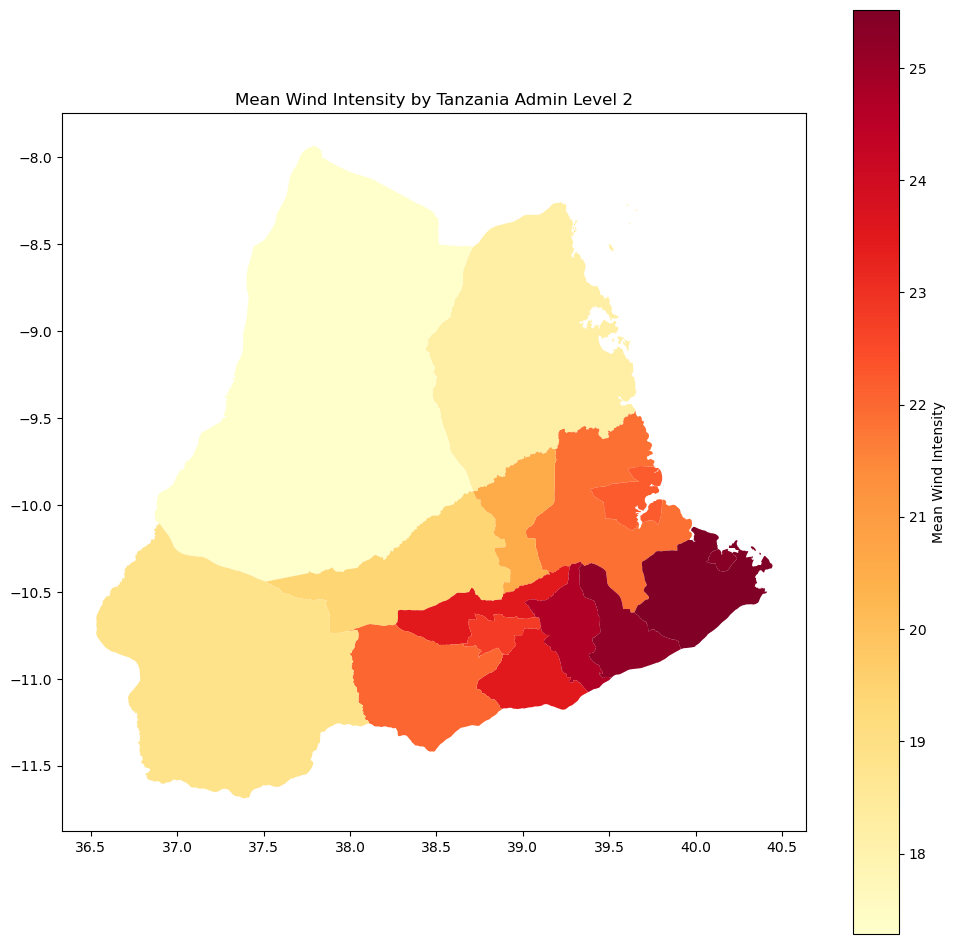

In [11]:
import os
import geopandas as gpd
import rasterio
import numpy as np
from rasterstats import zonal_stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Step 1: Define input folder and output folder
input_folder = r"X:\Work\Geodata\HZD\Tropical_cyclones\STORM\GLOBAL_MERGE\historical_1979-2014"
output_folder = r"X:\Work\adelphi\Geodata\TC"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created output folder: {output_folder}")

# Define the return periods and their file names
return_periods = {
    '10yr': 'STORM_FIXED_RETURN_PERIODS_GLOBAL_10_YR_RP.tif',
    '20yr': 'STORM_FIXED_RETURN_PERIODS_GLOBAL_20_YR_RP.tif',
    '50yr': 'STORM_FIXED_RETURN_PERIODS_GLOBAL_50_YR_RP.tif',
    '100yr': 'STORM_FIXED_RETURN_PERIODS_GLOBAL_100_YR_RP.tif',
    '500yr': 'STORM_FIXED_RETURN_PERIODS_GLOBAL_500_YR_RP.tif'
}

# Calculate exceedance probabilities and probability mass
exceedance_probs = {period: 1/int(period.replace('yr', '')) for period in return_periods.keys()}
sorted_periods = sorted(exceedance_probs.keys(), key=lambda x: int(x.replace('yr', '')))

prob_mass = {}
for i in range(len(sorted_periods)-1):
    current = sorted_periods[i]
    next_period = sorted_periods[i+1]
    prob_mass[current] = exceedance_probs[current] - exceedance_probs[next_period]
prob_mass[sorted_periods[-1]] = exceedance_probs[sorted_periods[-1]]

# Print weights for verification
print("Probability mass weights:")
for period in sorted_periods:
    print(f"{return_periods[period]}: {prob_mass[period]:.4f}")

# Step 2: Read all rasters and handle NoData properly
print("Reading raster files...")
rasters = []
masks = []
profile = None

for period in sorted_periods:
    file_path = os.path.join(input_folder, return_periods[period])
    with rasterio.open(file_path) as src:
        if profile is None:
            profile = src.profile
        
        data = src.read(1)
        mask = src.read_masks(1) == 0  # True where NoData
        
        rasters.append(data)
        masks.append(mask)

# Step 3: Create a combined mask (pixel is NoData only if it's NoData in ALL layers)
print("Combining rasters with weights and proper NoData handling...")
combined_mask = np.ones_like(masks[0], dtype=bool)
for mask in masks:
    combined_mask = combined_mask & mask  # Pixel is NoData only if ALL layers have NoData

# Step 4: Combine the rasters with their weights
weighted_sum = np.zeros_like(rasters[0], dtype=np.float32)
weight_sum = np.zeros_like(rasters[0], dtype=np.float32)

# Apply weights to valid pixels in each layer
for i, period in enumerate(sorted_periods):
    # Create a mask for this layer's valid data
    valid_mask = ~masks[i]
    
    # Apply weight only to valid pixels
    weighted_sum = np.where(valid_mask, 
                           weighted_sum + rasters[i] * prob_mass[period], 
                           weighted_sum)
    
    # Keep track of total weight applied to each pixel
    weight_sum = np.where(valid_mask,
                         weight_sum + prob_mass[period],
                         weight_sum)

# Normalize by the sum of weights for each pixel (avoiding division by zero)
weight_sum = np.where(weight_sum == 0, 1, weight_sum)  # Avoid division by zero
weighted_sum = weighted_sum / weight_sum

# Create a distance buffer from NoData edges to apply smoothing
# This helps reduce the edge artifacts
edge_buffer = 5  # pixels
edge_mask = np.zeros_like(combined_mask, dtype=bool)

# Identify pixels near NoData edges
for mask in masks:
    # Find boundary pixels (valid pixels adjacent to NoData)
    from scipy.ndimage import binary_dilation
    boundary = binary_dilation(mask, iterations=edge_buffer) & ~mask
    edge_mask = edge_mask | boundary

# Apply smoothing only to the edge regions
smoothed_sum = weighted_sum.copy()
valid_data_for_smoothing = ~combined_mask & edge_mask  # Only smooth valid data near edges

# Only apply smoothing to valid pixels near edges
if np.any(valid_data_for_smoothing):
    # Create a copy for smoothing to avoid affecting non-edge regions
    temp = weighted_sum.copy()
    
    # Replace NoData with nearest valid value for smoothing purposes
    from scipy.ndimage import distance_transform_edt, grey_dilation
    dist, indices = distance_transform_edt(combined_mask, return_distances=True, return_indices=True)
    temp_filled = np.zeros_like(temp)
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            if combined_mask[i, j]:
                # Get index of nearest non-NoData pixel
                ni, nj = indices[0, i, j], indices[1, i, j]
                temp_filled[i, j] = temp[ni, nj]
            else:
                temp_filled[i, j] = temp[i, j]
    
    # Apply Gaussian smoothing to filled data
    sigma = 1.0  # Adjust smoothing strength as needed
    smoothed_filled = gaussian_filter(temp_filled, sigma=sigma)
    
    # Only use smoothed values for edge regions
    smoothed_sum = np.where(valid_data_for_smoothing, smoothed_filled, weighted_sum)

# Apply the combined mask to the final result
final_sum = np.where(combined_mask, profile['nodata'], smoothed_sum)

# Write the combined raster
output_raster_path = os.path.join(output_folder, 'probability_weighted_wind_intensity_smooth.tif')
profile.update(dtype=rasterio.float32)
with rasterio.open(output_raster_path, 'w', **profile) as dst:
    dst.write(final_sum.astype(np.float32), 1)

print(f"Combined raster saved to: {output_raster_path}")

# Step 5: Load Tanzania admin level 2 boundaries
tanzania_shapefile = r"X:\Work\adelphi\Geodata\tza_adm2.gpkg"
print(f"Loading Tanzania admin boundaries from: {tanzania_shapefile}")
tanzania_adm2 = gpd.read_file(tanzania_shapefile)

# Step 6: Perform zonal statistics
print("Calculating zonal statistics...")
zs = zonal_stats(
    vectors=tanzania_adm2,
    raster=output_raster_path,
    stats=['mean'],
    all_touched=False,
    nodata=profile['nodata']
)

# Add the results to the GeoDataFrame
tanzania_adm2['mean_wind_intensity'] = [item['mean'] for item in zs]

# Step 7: Save the results
output_csv = os.path.join(output_folder, 'tanzania_adm2_wind_intensity.csv')
tanzania_adm2[['ADM2_EN', 'ADM1_EN', 'mean_wind_intensity']].to_csv(output_csv, index=False)
print(f"CSV saved to: {output_csv}")

output_geojson = os.path.join(output_folder, 'tanzania_adm2_wind_intensity.geojson')
tanzania_adm2.to_file(output_geojson, driver='GeoJSON')
print(f"GeoJSON saved to: {output_geojson}")

# Step 8: Create a map visualization
print("Creating map visualization...")
fig, ax = plt.subplots(figsize=(12, 12))
tanzania_adm2.plot(
    column='mean_wind_intensity',
    cmap='YlOrRd',
    legend=True,
    legend_kwds={'label': 'Mean Wind Intensity'},
    ax=ax
)
ax.set_title('Mean Wind Intensity by Tanzania Admin Level 2')
output_map = os.path.join(output_folder, 'tanzania_wind_intensity_map.png')
plt.savefig(output_map, dpi=300)
print(f"Map saved to: {output_map}")
print("Analysis complete!")